In [1]:

from numpy import loadtxt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
import eli5
import shap
import pandas as pd
import matplotlib.pyplot as plt

/home/bejar/.local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def classifier(num=0, rfnest=1000, rfdep=10, SVMC=10):
    if num==0:
        return RandomForestClassifier(n_estimators=rfnest,
                                     criterion='gini',
                                     max_depth=rfdep,
                                     min_samples_split=2,
                                     min_samples_leaf=1,
                                     min_weight_fraction_leaf=0.0,
                                     max_features=None,
                                     max_leaf_nodes=None,
                                     bootstrap=True,
                                     oob_score=False,
                                     n_jobs=1,
                                     class_weight='balanced')
    elif num == 1:
        return LogisticRegression(C=10000, penalty='l2',fit_intercept=False)
    elif num == 2:
        return LinearSVC(C=SVMC, fit_intercept=False)
    elif num ==3:
        return RidgeClassifier(alpha=2, fit_intercept=False)
    elif num == 4:
        return SVC(C=10000, gamma=0.01, kernel='rbf',degree=3, probability=True)
    
    
def diff_prediction(true, pred):
    for i, (t, p) in enumerate(zip(true, pred)):
        if t != p:
            print("Error instance %d, True=%d, Pred=%d" %(i,t,p))
        

In [3]:
from IPython.core.display import display, HTML
show_html = lambda html: display(HTML(html))
show_html_expl = lambda expl, **kwargs: show_html(eli5.format_as_html(expl, include_styles=False, **kwargs))
show_html(eli5.format_html_styles())
shap.initjs()

In [4]:
data = loadtxt('CVIrf.csv', delimiter=';', skiprows=1)
fnames = ['round','cadence','vel','sLength','sTime','sLengthCV','sTimeCV','rhfx','lhfx','rhfy','lhfy','rhfz','lhfz']
ncl = 6
X = data[:, 1:-ncl]
XNN = X.copy()
sc = MinMaxScaler()
X= sc.fit_transform(X)
X=pd.DataFrame(X, columns=fnames)

n_splits = 10

#  3 strides 3 clusters

In [20]:

yv = data[:, -ncl:]
print(yv.shape)
nlb = 0
y = yv[:,nlb].reshape(yv.shape[0])
nclasses = len(np.unique(y))


(153, 6)


## Random Forest

In [21]:

skf = StratifiedKFold(n_splits=n_splits)
skf.get_n_splits(X, y)

lacc = []
for train_index, test_index in skf.split(X, y):
    clf= classifier(num=0, rfnest=500, rfdep=8)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    prediction = clf.predict(X_test)
    acc = accuracy_score(y_test, prediction)
    lacc.append(acc)

print('ACC mean=', np.mean(lacc))

ACC mean= 0.7836904761904762


In [22]:
clf= classifier(num=0, rfnest=500, rfdep=8)

clf.fit(X, y)

y_hat = clf.predict(X)
print (classification_report(y_hat, y))
print (confusion_matrix(y_hat, y))
print('ACC=', accuracy_score(y, y_hat))

             precision    recall  f1-score   support

        1.0       1.00      1.00      1.00        50
        2.0       1.00      1.00      1.00        37
        3.0       1.00      1.00      1.00        66

avg / total       1.00      1.00      1.00       153

[[50  0  0]
 [ 0 37  0]
 [ 0  0 66]]
ACC= 1.0


### ELI5

In [23]:
expl = eli5.explain_weights(clf, feature_names=fnames)

show_html_expl(expl)

### SHAP

In [24]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)
shap.force_plot(explainer.expected_value[0], shap_values[0], X)

In [29]:
shap.force_plot(explainer.expected_value[0], shap_values[0][44,:], X.iloc[44,:])


In [32]:
X.iloc[44,:]
y[67]

3.0

In [26]:
shap.force_plot(explainer.expected_value[1], shap_values[1], X)

In [27]:
shap.force_plot(explainer.expected_value[2], shap_values[2], X)

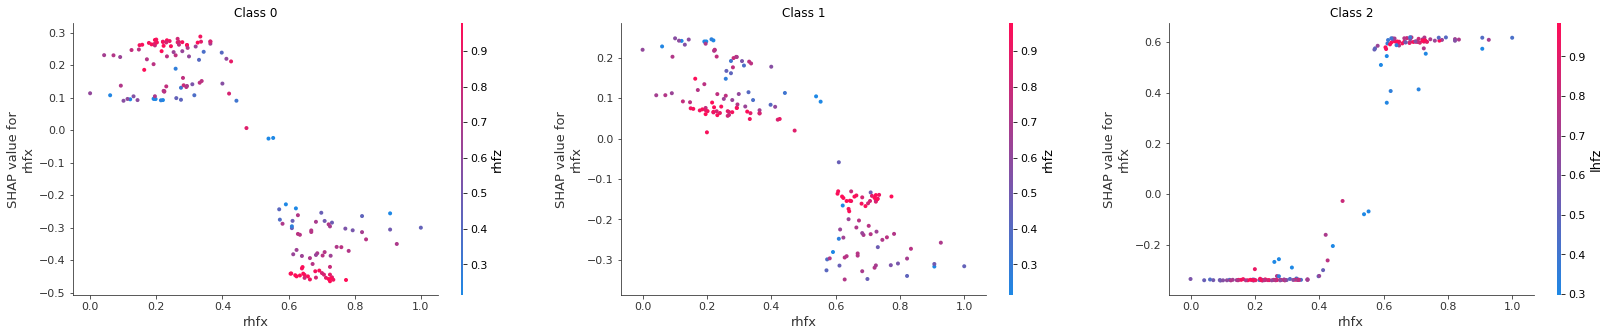

In [12]:
fig = plt.figure(figsize=(60,10))
for i in range(nclasses):
    ax = fig.add_subplot(1,nclasses,i+1)
    shap.dependence_plot('rhfx', shap_values[i], X, show=False)
    plt.title('Class %d'%i) 
plt.subplots_adjust(right=3)
plt.show()



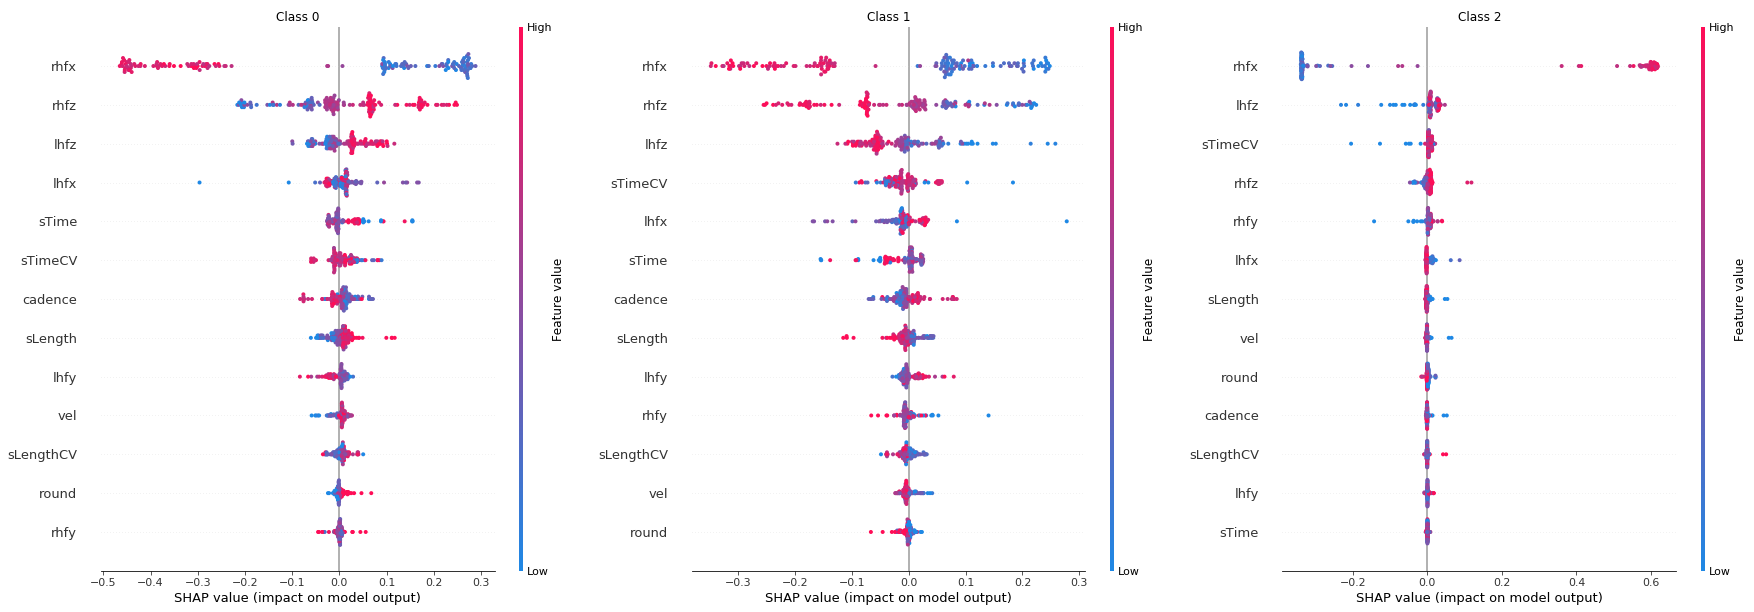

In [13]:
fig = plt.figure(figsize=(30,10))
for i in range(nclasses):
    ax = fig.add_subplot(1,nclasses,i+1)
    shap.summary_plot(shap_values[i], X, show=False,auto_size_plot=False)
    plt.title('Class %d'%i) 
plt.show()


In [14]:
shap_interaction_values = shap.TreeExplainer(clf).shap_interaction_values(X)

<Figure size 5760x720 with 0 Axes>

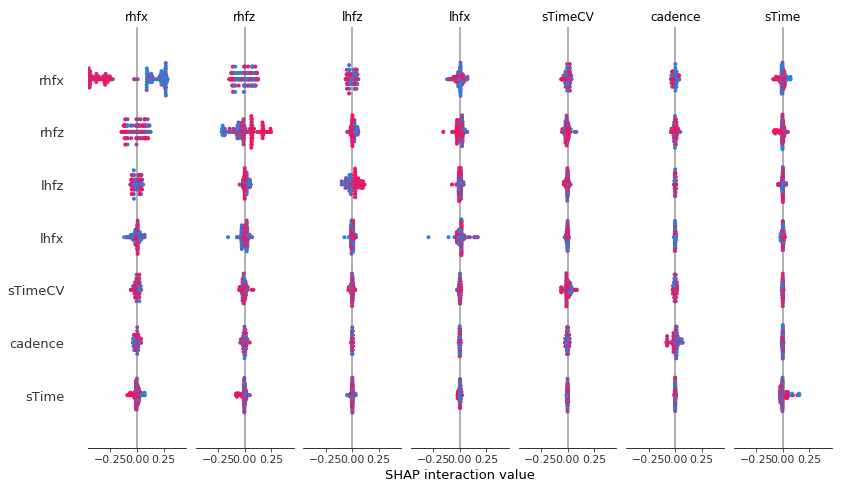

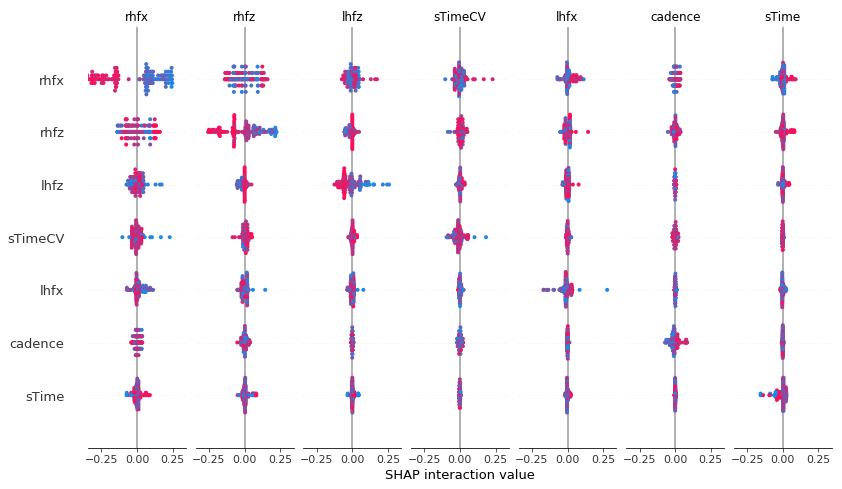

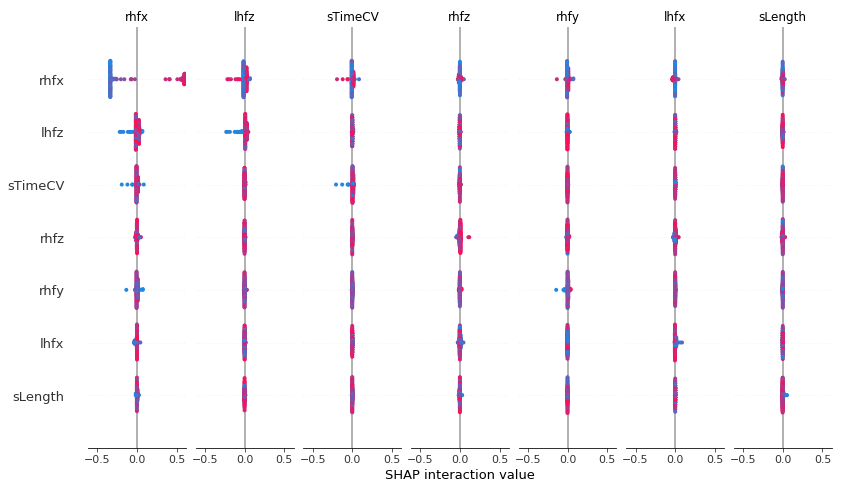

In [15]:
fig = plt.figure(figsize=(80,10))
for i in range(nclasses):
    shap.summary_plot(shap_interaction_values[i], X, show=False,auto_size_plot=False)
plt.show()

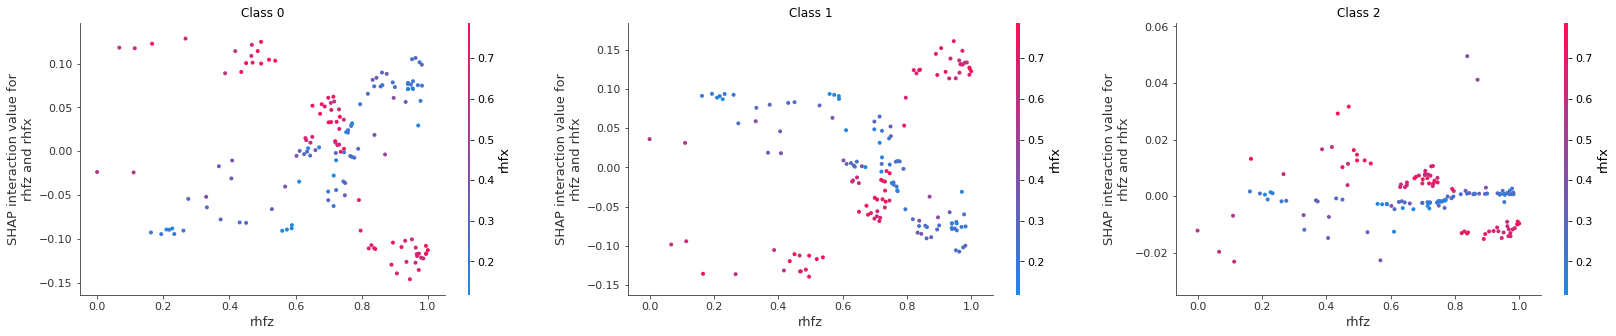

In [16]:

fig = plt.figure(figsize=(60,10))
for i in range(nclasses):
    ax = fig.add_subplot(1,nclasses,i+1)
    shap.dependence_plot(("rhfz", "rhfx"), shap_interaction_values[i], X, show=False)
    plt.title('Class %d'%i) 
plt.subplots_adjust(right=3)
plt.show()

## SVM

In [17]:
skf = StratifiedKFold(n_splits=n_splits)
skf.get_n_splits(X, y)

lacc = []
for train_index, test_index in skf.split(X, y):
    clf= classifier(num=2, SVMC=0.1)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    prediction = clf.predict(X_test)
    acc = accuracy_score(y_test, prediction)
    lacc.append(acc)

print('ACC mean=', np.mean(lacc))

ACC mean= 0.802797619047619


In [18]:
clf= classifier(num=2, SVMC=0.5)

clf.fit(X, y)

y_hat = clf.predict(X)
print (classification_report(y_hat, y))
print (confusion_matrix(y_hat, y))
print('ACC=', accuracy_score(y, y_hat))

             precision    recall  f1-score   support

        1.0       0.86      0.72      0.78        60
        2.0       0.43      0.67      0.52        24
        3.0       0.98      0.94      0.96        69

avg / total       0.85      0.81      0.82       153

[[43 17  0]
 [ 7 16  1]
 [ 0  4 65]]
ACC= 0.8104575163398693


In [19]:
diff_prediction(y, y_hat)

Error instance 8, True=2, Pred=1
Error instance 27, True=1, Pred=2
Error instance 30, True=2, Pred=3
Error instance 31, True=2, Pred=3
Error instance 40, True=1, Pred=2
Error instance 45, True=1, Pred=2
Error instance 51, True=3, Pred=2
Error instance 53, True=2, Pred=3
Error instance 54, True=2, Pred=1
Error instance 55, True=2, Pred=1
Error instance 56, True=2, Pred=1
Error instance 57, True=2, Pred=1
Error instance 70, True=1, Pred=2
Error instance 71, True=1, Pred=2
Error instance 72, True=1, Pred=2
Error instance 73, True=1, Pred=2
Error instance 74, True=2, Pred=1
Error instance 75, True=2, Pred=1
Error instance 76, True=2, Pred=1
Error instance 77, True=2, Pred=1
Error instance 90, True=2, Pred=1
Error instance 91, True=2, Pred=1
Error instance 114, True=2, Pred=1
Error instance 115, True=2, Pred=1
Error instance 116, True=2, Pred=1
Error instance 117, True=2, Pred=1
Error instance 119, True=2, Pred=1
Error instance 123, True=2, Pred=3
Error instance 140, True=2, Pred=1


In [20]:
expl = eli5.explain_weights(clf, feature_names=fnames)

show_html_expl(expl)

In [21]:
# explainer = shap.KernelExplainer(clf.predict_proba, X)
# shap_values = explainer.shap_values(X)

In [22]:
# shap.force_plot(explainer.expected_value[0], shap_values[0], X)

## Decision Tree

In [23]:
clf= DecisionTreeClassifier()

clf.fit(XNN, y)

y_hat = clf.predict(XNN)
print (classification_report(y_hat, y))
print (confusion_matrix(y_hat, y))
print('ACC=', accuracy_score(y, y_hat))
expl = eli5.explain_weights(clf, feature_names=fnames, rotate=True, filled=True, leaves_parallel=True, proportion=True)

show_html_expl(expl)

             precision    recall  f1-score   support

        1.0       1.00      1.00      1.00        50
        2.0       1.00      1.00      1.00        37
        3.0       1.00      1.00      1.00        66

avg / total       1.00      1.00      1.00       153

[[50  0  0]
 [ 0 37  0]
 [ 0  0 66]]
ACC= 1.0


# 5 strides 3 clusters

In [24]:
yv = data[:, -ncl:]
print(yv.shape)
nlb = 1
y = yv[:,nlb].reshape(yv.shape[0])
nclasses = len(np.unique(y))

(153, 6)


## Random Forest

In [25]:
skf = StratifiedKFold(n_splits=n_splits)
skf.get_n_splits(X, y)

lacc = []
for train_index, test_index in skf.split(X, y):
    clf= classifier(num=0, rfnest=500, rfdep=10)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    prediction = clf.predict(X_test)
    acc = accuracy_score(y_test, prediction)
    lacc.append(acc)

print('ACC mean=', np.mean(lacc))

ACC mean= 0.7518040293040292


In [26]:
clf= classifier(num=0, rfnest=500, rfdep=10)

clf.fit(X, y)

y_hat = clf.predict(X)
print (classification_report(y_hat, y))
print (confusion_matrix(y_hat, y))
print('ACC=', accuracy_score(y, y_hat))

             precision    recall  f1-score   support

        1.0       1.00      1.00      1.00        59
        2.0       1.00      1.00      1.00        56
        3.0       1.00      1.00      1.00        38

avg / total       1.00      1.00      1.00       153

[[59  0  0]
 [ 0 56  0]
 [ 0  0 38]]
ACC= 1.0


In [27]:
expl = eli5.explain_weights(clf, feature_names=fnames)

show_html_expl(expl)

### SHAP

In [28]:

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)
shap.force_plot(explainer.expected_value[0], shap_values[0], X)

In [29]:
shap.force_plot(explainer.expected_value[1], shap_values[1], X)

In [30]:
shap.force_plot(explainer.expected_value[2], shap_values[2], X)

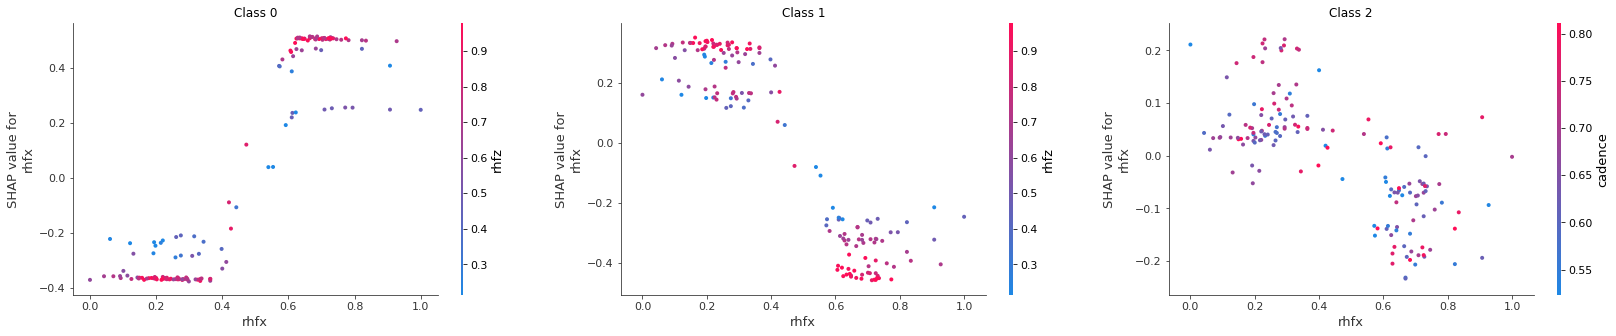

In [31]:
fig = plt.figure(figsize=(60,10))
for i in range(nclasses):
    ax = fig.add_subplot(1,nclasses,i+1)
    shap.dependence_plot('rhfx', shap_values[i], X, show=False)
    plt.title('Class %d'%i) 
plt.subplots_adjust(right=3)
plt.show()

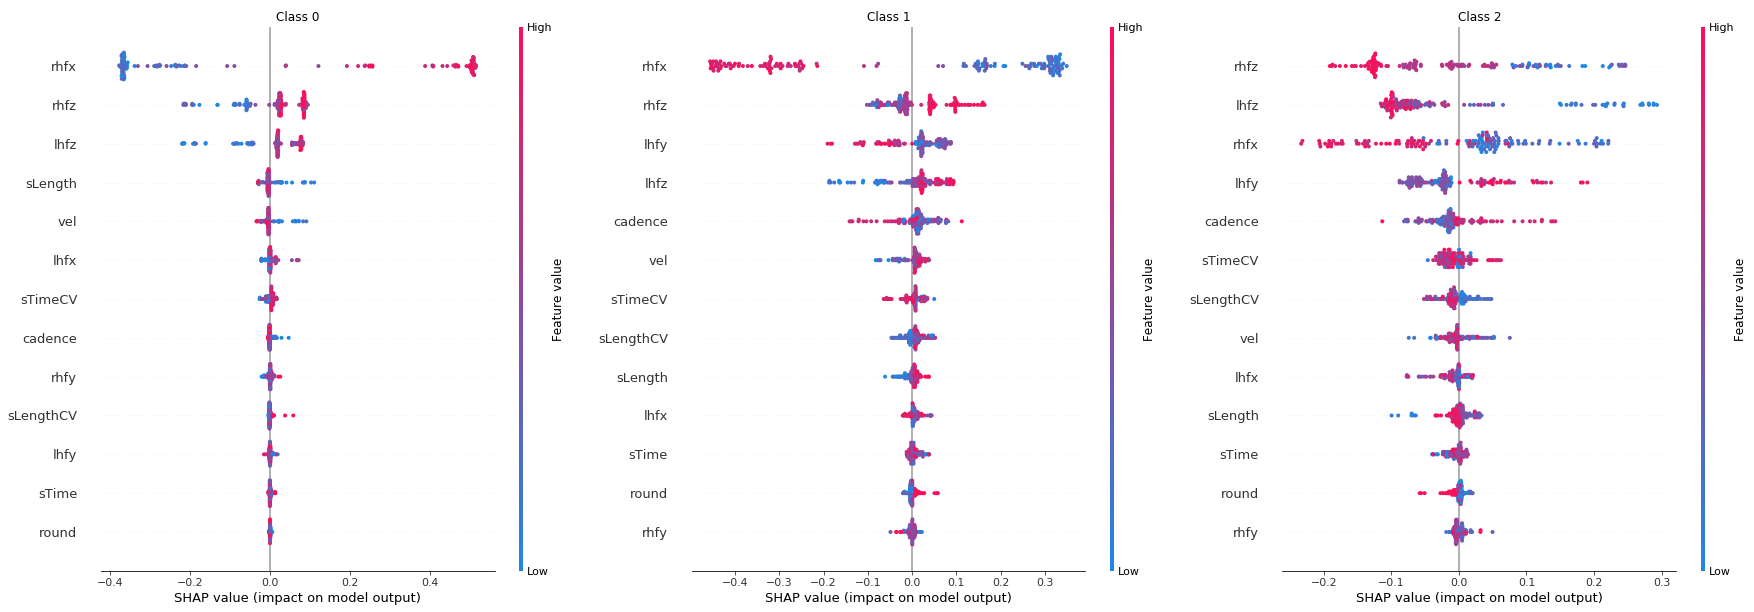

In [32]:

fig = plt.figure(figsize=(30,10))
for i in range(nclasses):
    ax = fig.add_subplot(1,nclasses,i+1)
    shap.summary_plot(shap_values[i], X, show=False,auto_size_plot=False)
    plt.title('Class %d'%i) 
plt.show()



In [33]:
shap_interaction_values = shap.TreeExplainer(clf).shap_interaction_values(X)

<Figure size 5760x720 with 0 Axes>

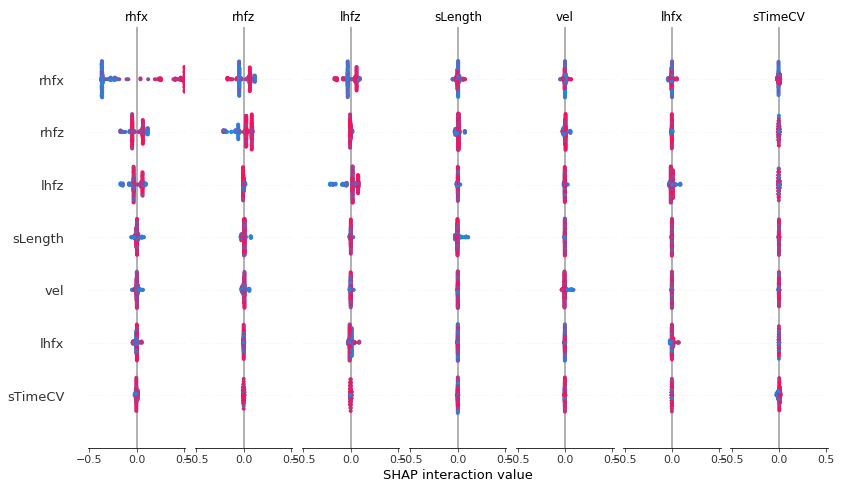

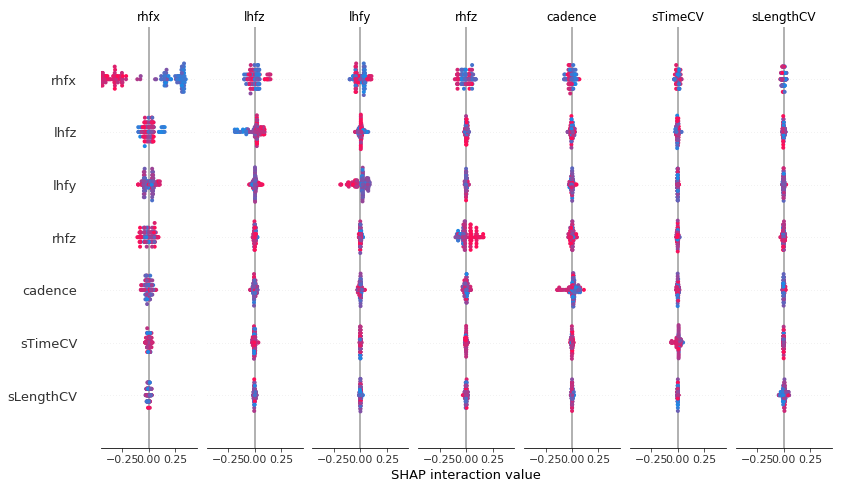

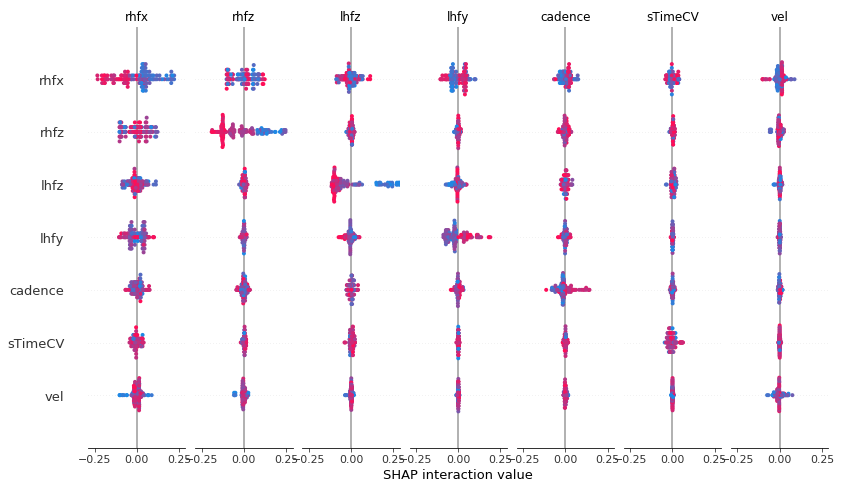

In [34]:
fig = plt.figure(figsize=(80,10))
for i in range(nclasses):
    shap.summary_plot(shap_interaction_values[i], X, show=False,auto_size_plot=False)
plt.show()

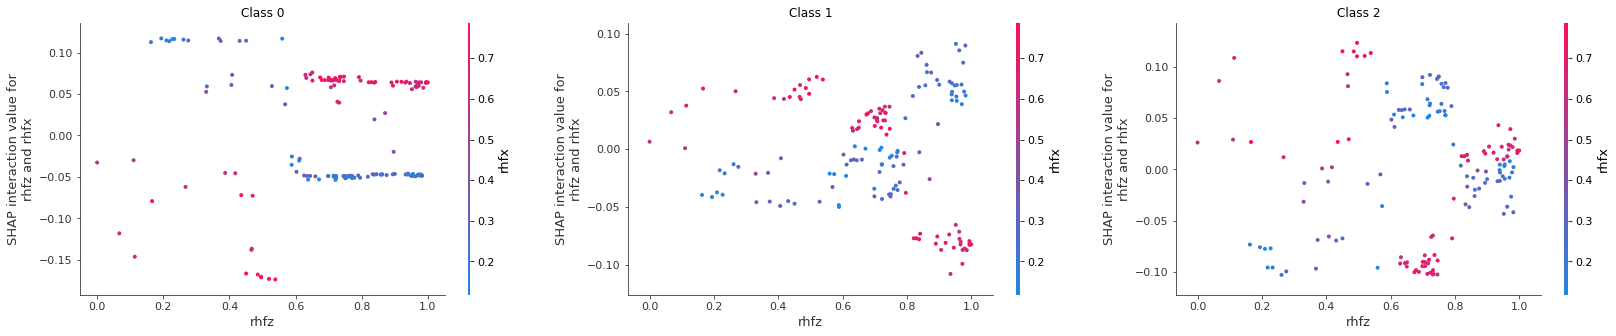

In [35]:
fig = plt.figure(figsize=(60,10))
for i in range(nclasses):
    ax = fig.add_subplot(1,nclasses,i+1)
    shap.dependence_plot(("rhfz", "rhfx"), shap_interaction_values[i], X, show=False)
    plt.title('Class %d'%i) 
plt.subplots_adjust(right=3)
plt.show()

## SVM

In [36]:
skf = StratifiedKFold(n_splits=n_splits)
skf.get_n_splits(X, y)

lacc = []
for train_index, test_index in skf.split(X, y):
    clf= classifier(num=2, SVMC=0.1)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    prediction = clf.predict(X_test)
    acc = accuracy_score(y_test, prediction)
    lacc.append(acc)

print('ACC mean=', np.mean(lacc))

ACC mean= 0.7959111721611721


In [37]:
clf= classifier(num=2, SVMC=0.1)

clf.fit(X, y)

y_hat = clf.predict(X)
print (classification_report(y_hat, y))
print (confusion_matrix(y_hat, y))
print('ACC=', accuracy_score(y, y_hat))

             precision    recall  f1-score   support

        1.0       0.98      0.87      0.92        67
        2.0       0.89      0.77      0.83        65
        3.0       0.37      0.67      0.47        21

avg / total       0.86      0.80      0.82       153

[[58  0  9]
 [ 0 50 15]
 [ 1  6 14]]
ACC= 0.7973856209150327


In [38]:
diff_prediction(y, y_hat)

Error instance 22, True=2, Pred=3
Error instance 23, True=2, Pred=3
Error instance 25, True=3, Pred=2
Error instance 28, True=3, Pred=1
Error instance 29, True=3, Pred=1
Error instance 30, True=3, Pred=1
Error instance 31, True=3, Pred=1
Error instance 37, True=1, Pred=3
Error instance 44, True=2, Pred=3
Error instance 45, True=2, Pred=3
Error instance 55, True=3, Pred=2
Error instance 56, True=3, Pred=2
Error instance 70, True=2, Pred=3
Error instance 71, True=2, Pred=3
Error instance 74, True=3, Pred=2
Error instance 75, True=3, Pred=2
Error instance 76, True=3, Pred=2
Error instance 77, True=3, Pred=2
Error instance 90, True=3, Pred=2
Error instance 91, True=3, Pred=2
Error instance 92, True=3, Pred=2
Error instance 114, True=3, Pred=2
Error instance 115, True=3, Pred=2
Error instance 117, True=3, Pred=2
Error instance 119, True=3, Pred=2
Error instance 123, True=3, Pred=1
Error instance 124, True=3, Pred=2
Error instance 149, True=3, Pred=1
Error instance 150, True=3, Pred=1
Error 

In [39]:
expl = eli5.explain_weights(clf, feature_names=fnames)

show_html_expl(expl)

## Decision tree

In [40]:
clf= DecisionTreeClassifier()

clf.fit(XNN, y)

y_hat = clf.predict(XNN)
print (classification_report(y_hat, y))
print (confusion_matrix(y_hat, y))
print('ACC=', accuracy_score(y, y_hat))
expl = eli5.explain_weights(clf, feature_names=fnames, rotate=True, filled=True, leaves_parallel=True, proportion=True)

show_html_expl(expl)

             precision    recall  f1-score   support

        1.0       1.00      1.00      1.00        59
        2.0       1.00      1.00      1.00        56
        3.0       1.00      1.00      1.00        38

avg / total       1.00      1.00      1.00       153

[[59  0  0]
 [ 0 56  0]
 [ 0  0 38]]
ACC= 1.0


# 5 strides 5 clusters

In [41]:
yv = data[:, -ncl:]
print(yv.shape)
nlb = 2
y = yv[:,nlb].reshape(yv.shape[0])
nclasses = len(np.unique(y))

(153, 6)


## Random Forest

In [42]:
skf = StratifiedKFold(n_splits=n_splits)
skf.get_n_splits(X, y)

lacc = []
for train_index, test_index in skf.split(X, y):
    clf= classifier(num=0, rfnest=1000, rfdep=8)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    prediction = clf.predict(X_test)
    acc = accuracy_score(y_test, prediction)
    lacc.append(acc)

print('ACC mean=', np.mean(lacc))

ACC mean= 0.7796719457013574


In [43]:
clf= classifier(num=0, rfnest=1000, rfdep=8)

clf.fit(X, y)

y_hat = clf.predict(X)
print (classification_report(y_hat, y))
print (confusion_matrix(y_hat, y))
print('ACC=', accuracy_score(y, y_hat))

             precision    recall  f1-score   support

        1.0       1.00      1.00      1.00        30
        2.0       1.00      1.00      1.00        58
        3.0       1.00      1.00      1.00        18
        4.0       1.00      1.00      1.00        25
        5.0       1.00      1.00      1.00        22

avg / total       1.00      1.00      1.00       153

[[30  0  0  0  0]
 [ 0 58  0  0  0]
 [ 0  0 18  0  0]
 [ 0  0  0 25  0]
 [ 0  0  0  0 22]]
ACC= 1.0


In [44]:
expl = eli5.explain_weights(clf, feature_names=fnames)

show_html_expl(expl)

### SHAP

In [45]:

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)
shap.force_plot(explainer.expected_value[0], shap_values[0], X)

In [46]:
shap.force_plot(explainer.expected_value[1], shap_values[1], X)

In [47]:
shap.force_plot(explainer.expected_value[2], shap_values[2], X)

In [48]:
shap.force_plot(explainer.expected_value[3], shap_values[3], X)

In [49]:
shap.force_plot(explainer.expected_value[4], shap_values[4], X)

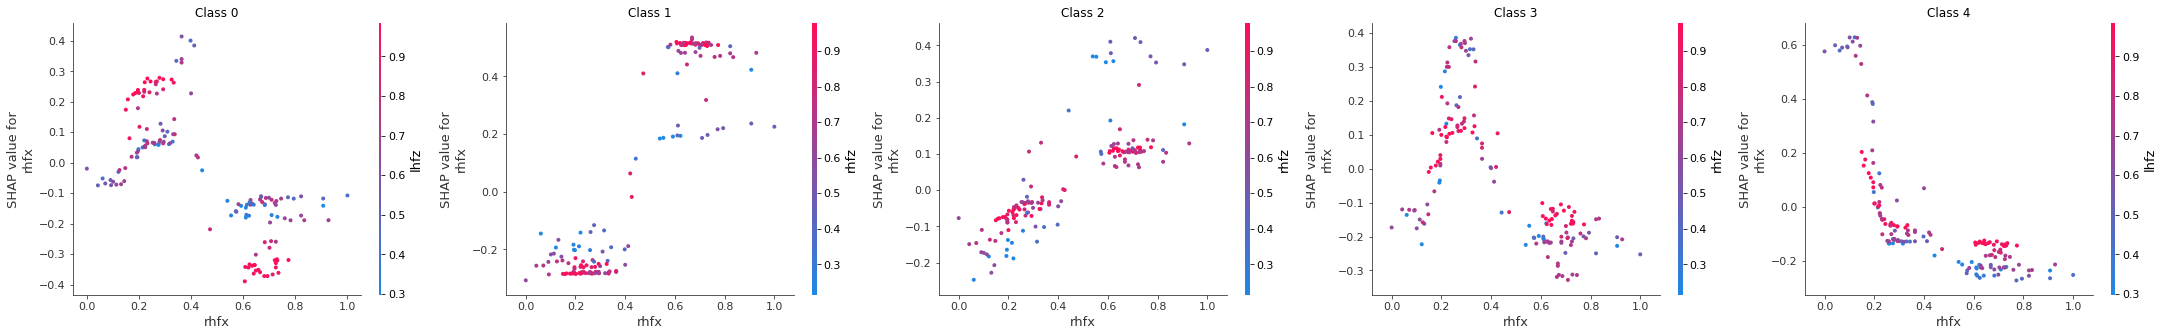

In [50]:
fig = plt.figure(figsize=(60,10))
for i in range(nclasses):
    ax = fig.add_subplot(1,nclasses,i+1)
    shap.dependence_plot('rhfx', shap_values[i], X, show=False)
    plt.title('Class %d'%i) 
plt.subplots_adjust(right=4)
plt.show()

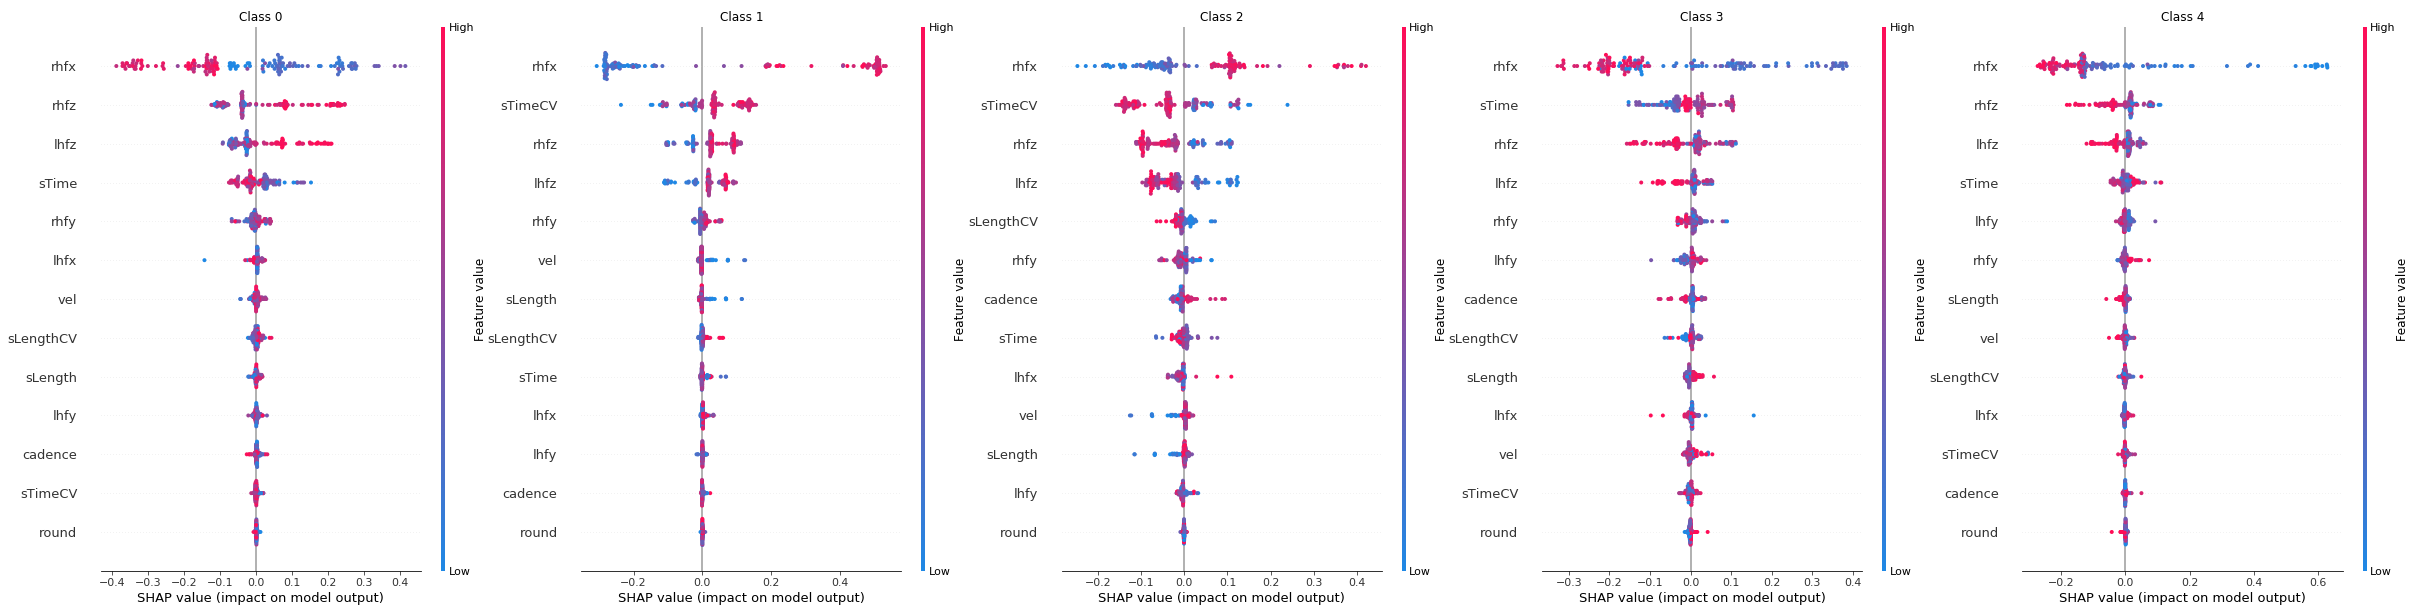

In [51]:
fig = plt.figure(figsize=(30,10))
for i in range(nclasses):
    ax = fig.add_subplot(1,nclasses,i+1)
    shap.summary_plot(shap_values[i], X, show=False,auto_size_plot=False)
    plt.title('Class %d'%i) 
plt.subplots_adjust(right=1.2)
plt.show()

In [52]:
shap_interaction_values = shap.TreeExplainer(clf).shap_interaction_values(X)

<Figure size 5760x720 with 0 Axes>

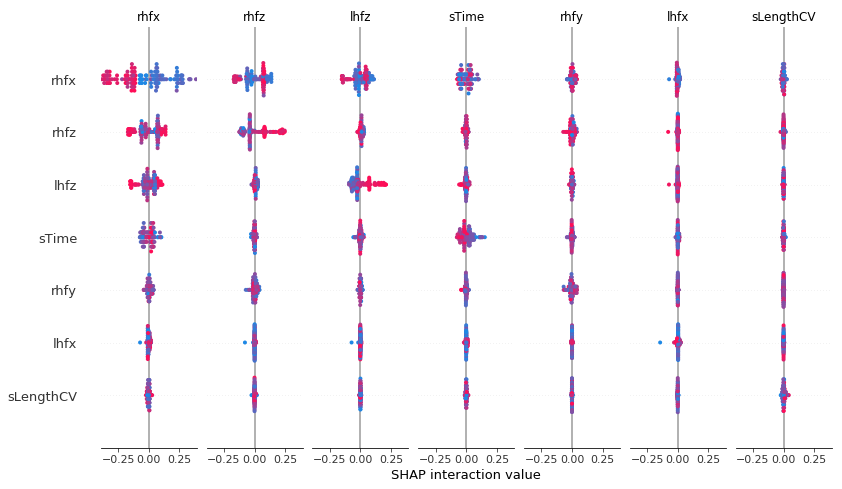

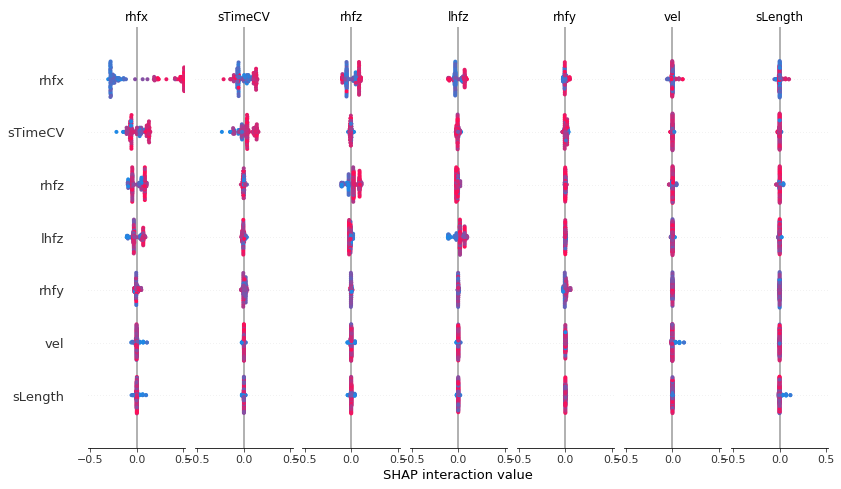

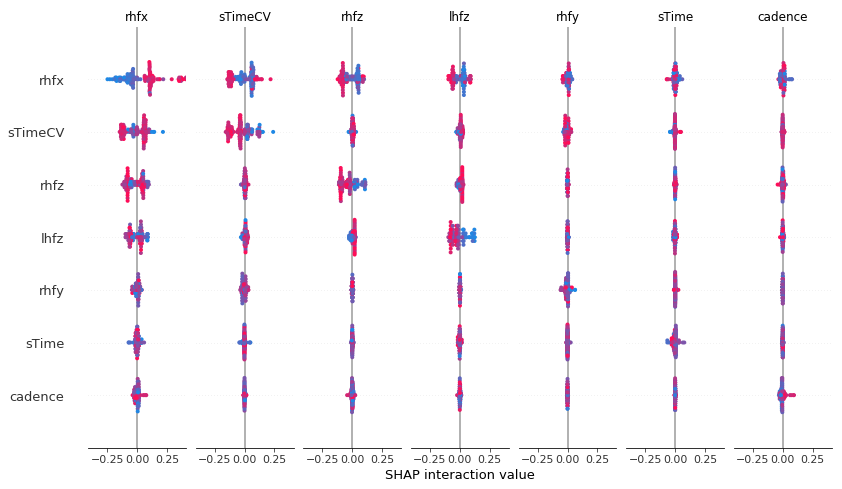

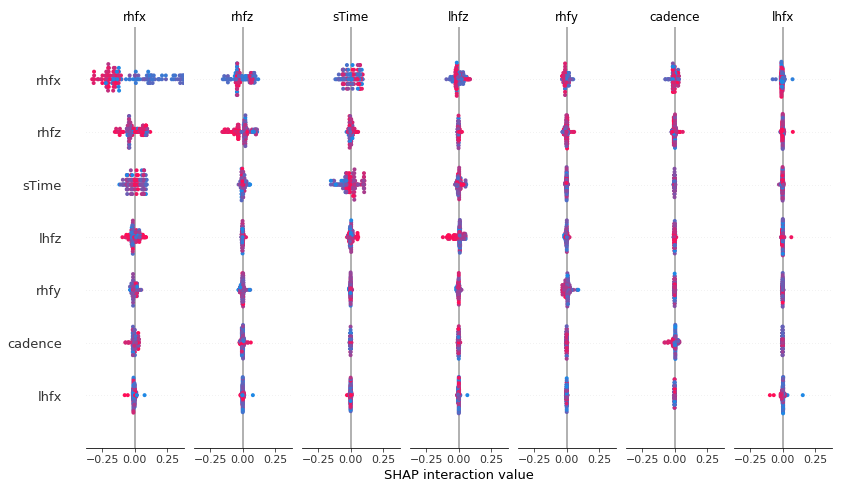

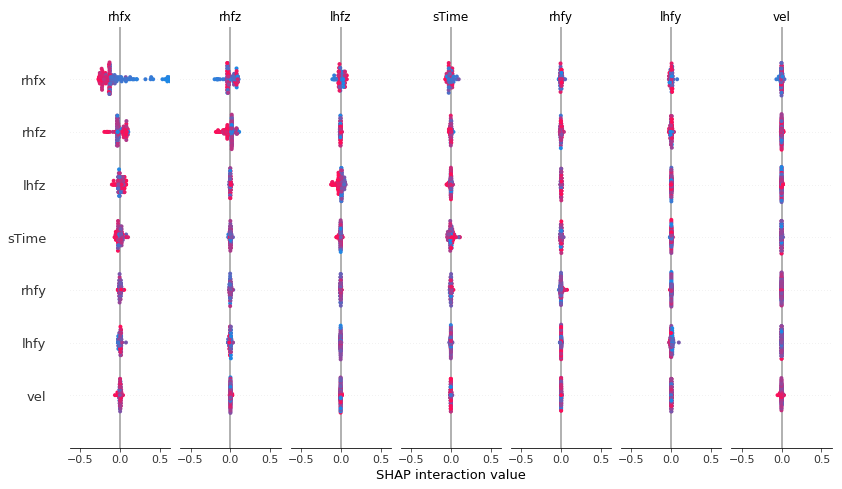

In [53]:
fig = plt.figure(figsize=(80,10))
for i in range(nclasses):
    shap.summary_plot(shap_interaction_values[i], X, show=False,auto_size_plot=False)
plt.show()

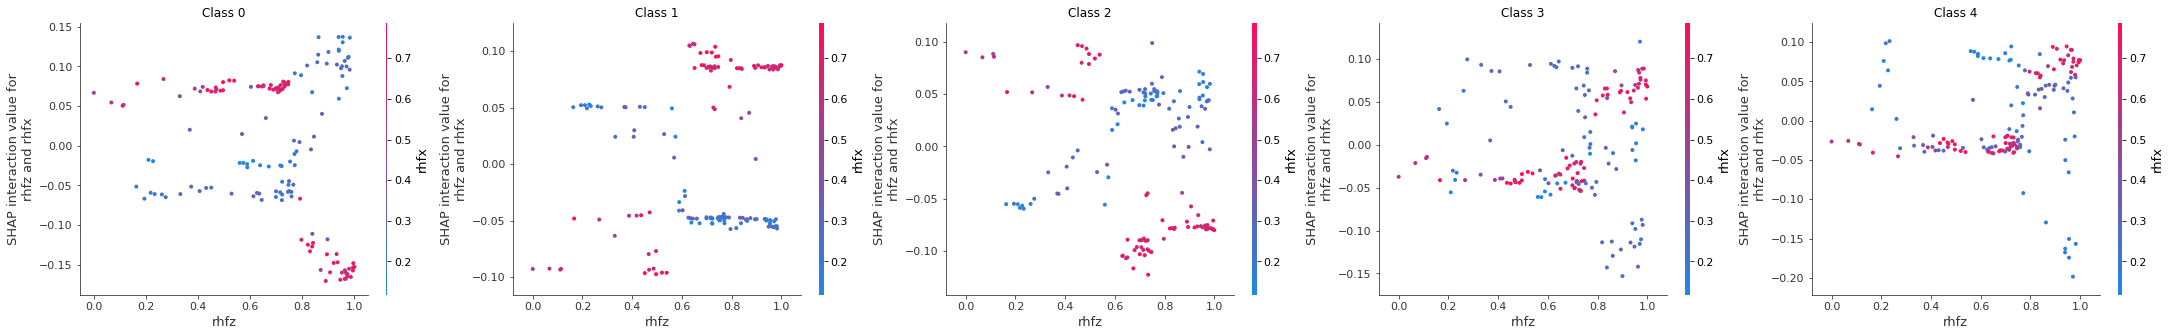

In [54]:
fig = plt.figure(figsize=(60,20))
for i in range(nclasses):
    ax = fig.add_subplot(1,nclasses,i+1)
    shap.dependence_plot(("rhfz", "rhfx"), shap_interaction_values[i], X, show=False)
    plt.title('Class %d'%i) 
plt.subplots_adjust(right=4)
plt.show()

## SVM

In [55]:
skf = StratifiedKFold(n_splits=n_splits)
skf.get_n_splits(X, y)

lacc = []
for train_index, test_index in skf.split(X, y):
    clf= classifier(num=2, SVMC=10)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    prediction = clf.predict(X_test)
    acc = accuracy_score(y_test, prediction)
    lacc.append(acc)

print('ACC mean=', np.mean(lacc))

ACC mean= 0.6928242835595777


In [56]:
clf= classifier(num=2, SVMC=10)

clf.fit(X, y)

y_hat = clf.predict(X)
print (classification_report(y_hat, y))
print (confusion_matrix(y_hat, y))
print('ACC=', accuracy_score(y, y_hat))

             precision    recall  f1-score   support

        1.0       0.80      0.73      0.76        33
        2.0       0.97      0.92      0.94        61
        3.0       0.67      0.75      0.71        16
        4.0       0.52      0.65      0.58        20
        5.0       0.82      0.78      0.80        23

avg / total       0.82      0.80      0.81       153

[[24  0  0  8  1]
 [ 0 56  4  0  1]
 [ 2  2 12  0  0]
 [ 4  0  1 13  2]
 [ 0  0  1  4 18]]
ACC= 0.803921568627451


In [57]:
diff_prediction(y, y_hat)

Error instance 26, True=4, Pred=5
Error instance 29, True=3, Pred=2
Error instance 30, True=3, Pred=2
Error instance 32, True=3, Pred=2
Error instance 36, True=2, Pred=3
Error instance 37, True=2, Pred=3
Error instance 41, True=4, Pred=5
Error instance 42, True=4, Pred=5
Error instance 44, True=4, Pred=5
Error instance 70, True=1, Pred=3
Error instance 71, True=1, Pred=3
Error instance 72, True=1, Pred=4
Error instance 73, True=1, Pred=4
Error instance 74, True=3, Pred=5
Error instance 76, True=5, Pred=4
Error instance 77, True=3, Pred=4
Error instance 84, True=4, Pred=1
Error instance 85, True=4, Pred=1
Error instance 90, True=4, Pred=1
Error instance 91, True=4, Pred=1
Error instance 92, True=4, Pred=1
Error instance 93, True=4, Pred=1
Error instance 114, True=4, Pred=1
Error instance 115, True=5, Pred=4
Error instance 123, True=5, Pred=2
Error instance 137, True=1, Pred=4
Error instance 138, True=4, Pred=1
Error instance 139, True=1, Pred=4
Error instance 145, True=5, Pred=1
Error i

In [58]:
expl = eli5.explain_weights(clf, feature_names=fnames)

show_html_expl(expl)

## Decision tree

In [59]:
clf= DecisionTreeClassifier()

clf.fit(XNN, y)

y_hat = clf.predict(XNN)
print (classification_report(y_hat, y))
print (confusion_matrix(y_hat, y))
print('ACC=', accuracy_score(y, y_hat))
expl = eli5.explain_weights(clf, feature_names=fnames, rotate=True, filled=True, leaves_parallel=True, proportion=True)

show_html_expl(expl)

             precision    recall  f1-score   support

        1.0       1.00      1.00      1.00        30
        2.0       1.00      1.00      1.00        58
        3.0       1.00      1.00      1.00        18
        4.0       1.00      1.00      1.00        25
        5.0       1.00      1.00      1.00        22

avg / total       1.00      1.00      1.00       153

[[30  0  0  0  0]
 [ 0 58  0  0  0]
 [ 0  0 18  0  0]
 [ 0  0  0 25  0]
 [ 0  0  0  0 22]]
ACC= 1.0


# 6 strides 3 clusters

In [60]:
yv = data[:, -ncl:]
print(yv.shape)
nlb = 4
y = yv[:,nlb].reshape(yv.shape[0])
nclasses = len(np.unique(y))

(153, 6)


## Random Forest

In [61]:
skf = StratifiedKFold(n_splits=n_splits)
skf.get_n_splits(X, y)

lacc = []
for train_index, test_index in skf.split(X, y):
    clf= classifier(num=0, rfnest=1000, rfdep=8)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    prediction = clf.predict(X_test)
    acc = accuracy_score(y_test, prediction)
    lacc.append(acc)

print('ACC mean=', np.mean(lacc))

ACC mean= 0.7878205128205129


In [62]:
clf= classifier(num=0, rfnest=1000, rfdep=8)

clf.fit(X, y)

y_hat = clf.predict(X)
print (classification_report(y_hat, y))
print (confusion_matrix(y_hat, y))
print('ACC=', accuracy_score(y, y_hat))

             precision    recall  f1-score   support

        1.0       1.00      1.00      1.00        49
        2.0       1.00      1.00      1.00        58
        3.0       1.00      1.00      1.00        46

avg / total       1.00      1.00      1.00       153

[[49  0  0]
 [ 0 58  0]
 [ 0  0 46]]
ACC= 1.0


In [63]:
expl = eli5.explain_weights(clf, feature_names=fnames)

show_html_expl(expl)

### SHAP

In [64]:

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)
shap.force_plot(explainer.expected_value[0], shap_values[0], X)

In [65]:
shap.force_plot(explainer.expected_value[1], shap_values[1], X)

In [66]:
shap.force_plot(explainer.expected_value[2], shap_values[2], X)

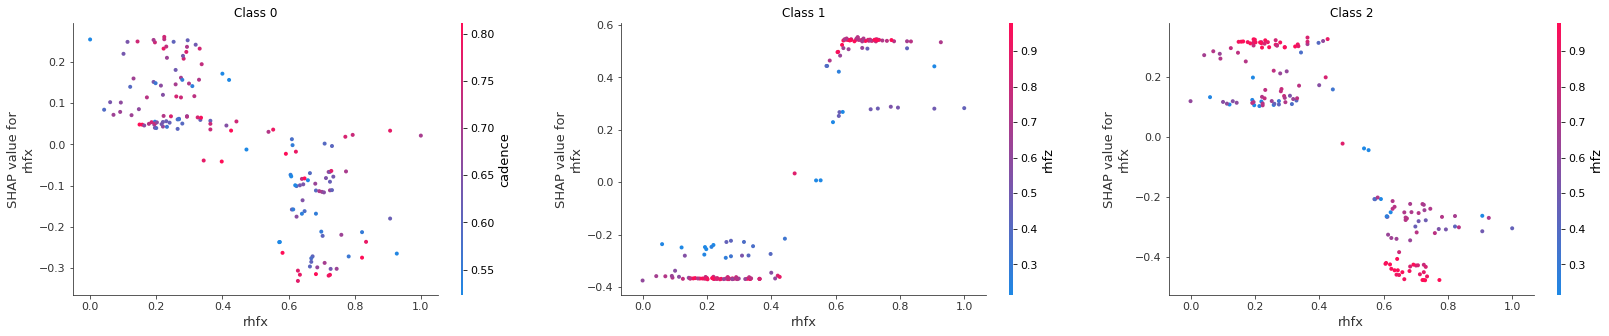

In [67]:
fig = plt.figure(figsize=(60,10))
for i in range(nclasses):
    ax = fig.add_subplot(1,nclasses,i+1)
    shap.dependence_plot('rhfx', shap_values[i], X, show=False)
    plt.title('Class %d'%i) 
plt.subplots_adjust(right=3)
plt.show()

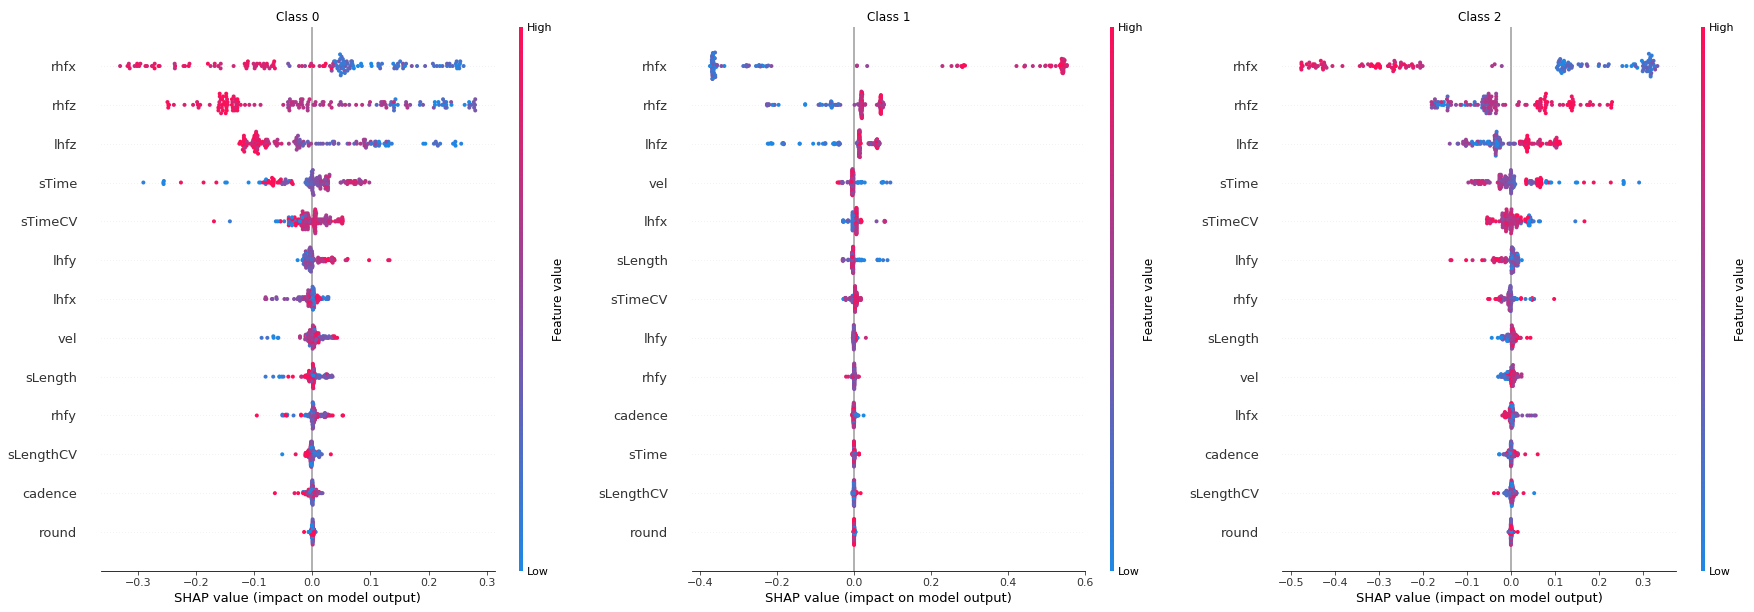

In [68]:

fig = plt.figure(figsize=(30,10))
for i in range(nclasses):
    ax = fig.add_subplot(1,nclasses,i+1)
    shap.summary_plot(shap_values[i], X, show=False,auto_size_plot=False)
    plt.title('Class %d'%i) 
plt.show()



In [69]:
shap_interaction_values = shap.TreeExplainer(clf).shap_interaction_values(X)

<Figure size 5760x720 with 0 Axes>

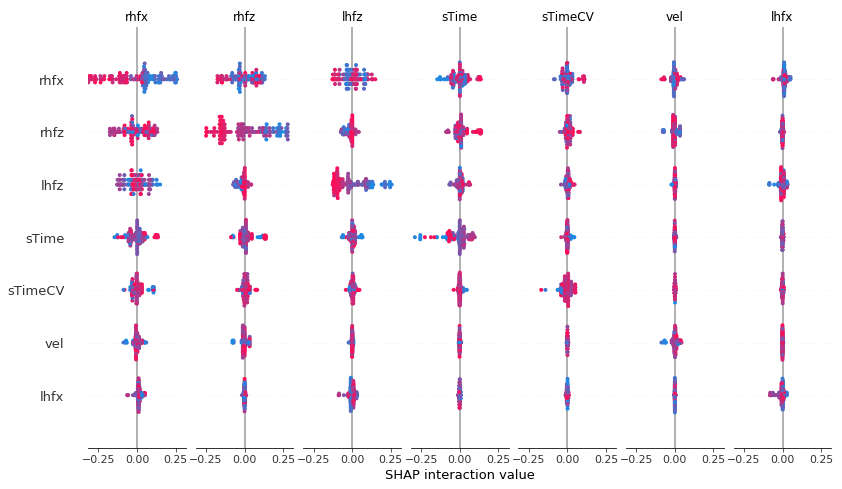

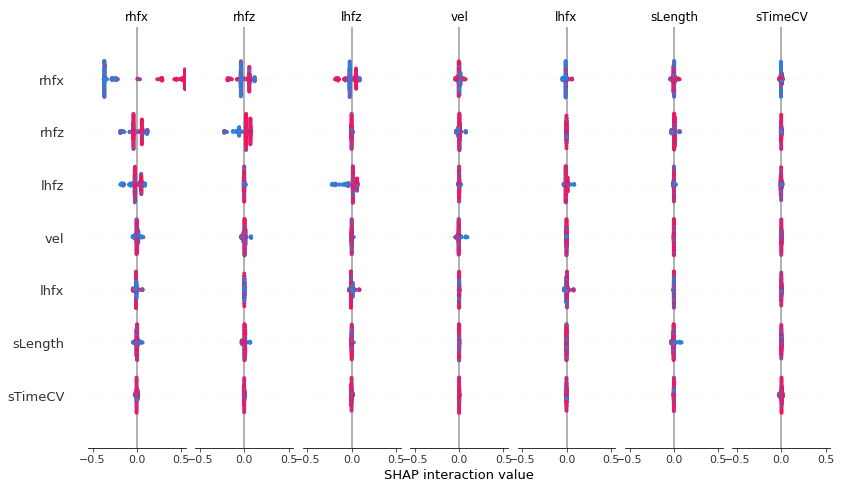

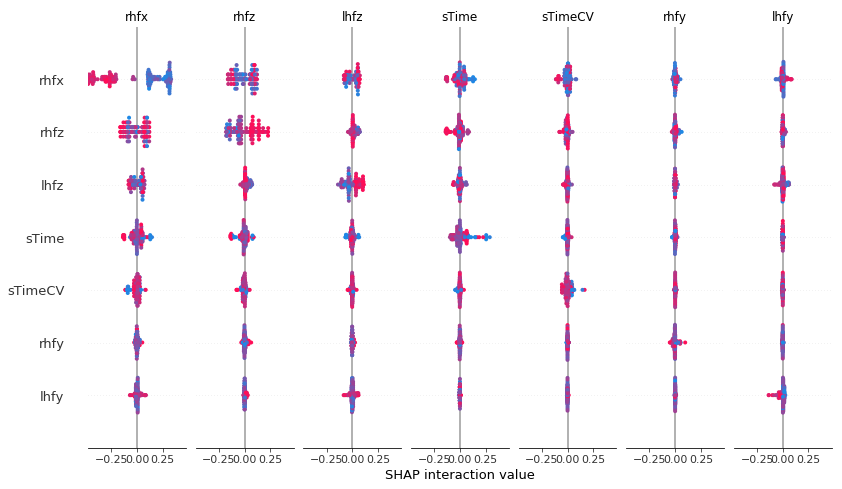

In [70]:
fig = plt.figure(figsize=(80,10))
for i in range(nclasses):
    shap.summary_plot(shap_interaction_values[i], X, show=False,auto_size_plot=False)
plt.show()

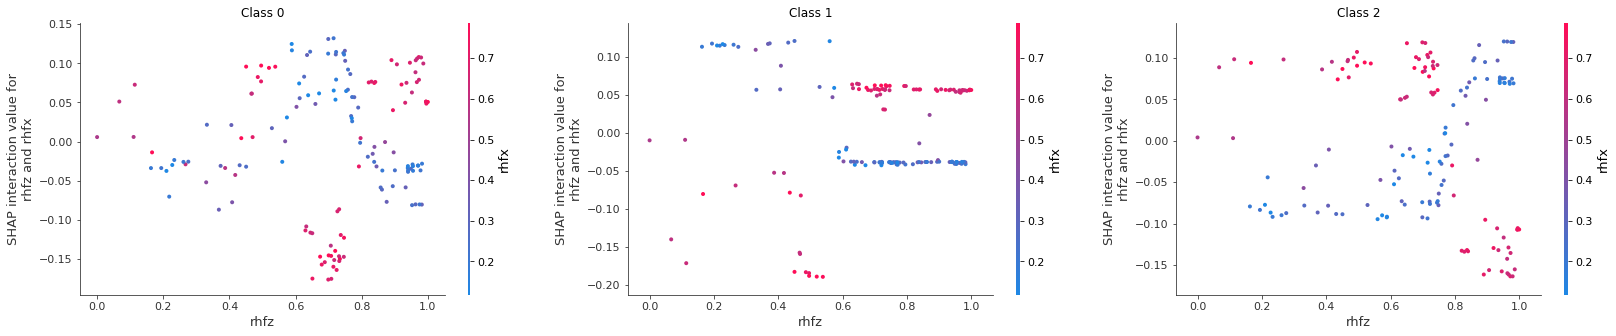

In [71]:
fig = plt.figure(figsize=(60,10))
for i in range(nclasses):
    ax = fig.add_subplot(1,nclasses,i+1)
    shap.dependence_plot(("rhfz", "rhfx"), shap_interaction_values[i], X, show=False)
    plt.title('Class %d'%i) 
plt.subplots_adjust(right=3)
plt.show()

## SVM

In [72]:
skf = StratifiedKFold(n_splits=n_splits)
skf.get_n_splits(X, y)

lacc = []
for train_index, test_index in skf.split(X, y):
    clf= classifier(num=2, SVMC=0.1)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    prediction = clf.predict(X_test)
    acc = accuracy_score(y_test, prediction)
    lacc.append(acc)

print('ACC mean=', np.mean(lacc))

ACC mean= 0.753191391941392


In [73]:
clf= classifier(num=2, SVMC=0.1)

clf.fit(X, y)

y_hat = clf.predict(X)
print (classification_report(y_hat, y))
print (confusion_matrix(y_hat, y))
print('ACC=', accuracy_score(y, y_hat))

             precision    recall  f1-score   support

        1.0       0.47      0.74      0.58        31
        2.0       0.98      0.85      0.91        67
        3.0       0.85      0.71      0.77        55

avg / total       0.83      0.78      0.79       153

[[23  1  7]
 [10 57  0]
 [16  0 39]]
ACC= 0.7777777777777778


In [74]:
diff_prediction(y, y_hat)

Error instance 22, True=3, Pred=1
Error instance 27, True=3, Pred=1
Error instance 28, True=1, Pred=2
Error instance 29, True=1, Pred=2
Error instance 30, True=1, Pred=2
Error instance 31, True=1, Pred=2
Error instance 37, True=2, Pred=1
Error instance 39, True=1, Pred=2
Error instance 54, True=1, Pred=3
Error instance 55, True=1, Pred=3
Error instance 56, True=1, Pred=3
Error instance 57, True=1, Pred=3
Error instance 70, True=3, Pred=1
Error instance 71, True=3, Pred=1
Error instance 72, True=3, Pred=1
Error instance 73, True=3, Pred=1
Error instance 74, True=1, Pred=3
Error instance 75, True=1, Pred=3
Error instance 76, True=1, Pred=3
Error instance 77, True=1, Pred=3
Error instance 90, True=1, Pred=3
Error instance 91, True=1, Pred=3
Error instance 92, True=1, Pred=3
Error instance 110, True=3, Pred=1
Error instance 114, True=1, Pred=3
Error instance 115, True=1, Pred=3
Error instance 116, True=1, Pred=3
Error instance 117, True=1, Pred=3
Error instance 118, True=1, Pred=3
Error in

In [75]:
expl = eli5.explain_weights(clf, feature_names=fnames)

show_html_expl(expl)

## Decision tree

In [76]:
clf= DecisionTreeClassifier()

clf.fit(XNN, y)

y_hat = clf.predict(XNN)
print (classification_report(y_hat, y))
print (confusion_matrix(y_hat, y))
print('ACC=', accuracy_score(y, y_hat))
expl = eli5.explain_weights(clf, feature_names=fnames, rotate=True, filled=True, leaves_parallel=True, proportion=True)

show_html_expl(expl)

             precision    recall  f1-score   support

        1.0       1.00      1.00      1.00        49
        2.0       1.00      1.00      1.00        58
        3.0       1.00      1.00      1.00        46

avg / total       1.00      1.00      1.00       153

[[49  0  0]
 [ 0 58  0]
 [ 0  0 46]]
ACC= 1.0


# 6 strides 4 clusters

In [77]:
yv = data[:, -ncl:]
print(yv.shape)
nlb = 5
y = yv[:,nlb].reshape(yv.shape[0])
nclasses = len(np.unique(y))

(153, 6)


## Random Forest

In [78]:
skf = StratifiedKFold(n_splits=n_splits)
skf.get_n_splits(X, y)

lacc = []
for train_index, test_index in skf.split(X, y):
    clf= classifier(num=0, rfnest=1000, rfdep=8)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    prediction = clf.predict(X_test)
    acc = accuracy_score(y_test, prediction)
    lacc.append(acc)

print('ACC mean=', np.mean(lacc))

ACC mean= 0.8093872549019607


In [79]:
clf= classifier(num=0, rfnest=1000, rfdep=8)

clf.fit(X, y)

y_hat = clf.predict(X)
print (classification_report(y_hat, y))
print (confusion_matrix(y_hat, y))
print('ACC=', accuracy_score(y, y_hat))

             precision    recall  f1-score   support

        1.0       1.00      1.00      1.00        32
        2.0       1.00      1.00      1.00        41
        3.0       1.00      1.00      1.00        23
        4.0       1.00      1.00      1.00        57

avg / total       1.00      1.00      1.00       153

[[32  0  0  0]
 [ 0 41  0  0]
 [ 0  0 23  0]
 [ 0  0  0 57]]
ACC= 1.0


In [80]:
expl = eli5.explain_weights(clf, feature_names=fnames)

show_html_expl(expl)

### SHAP

In [81]:

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)
shap.force_plot(explainer.expected_value[0], shap_values[0], X)

In [82]:
shap.force_plot(explainer.expected_value[1], shap_values[1], X)

In [83]:
shap.force_plot(explainer.expected_value[2], shap_values[2], X)

In [84]:
shap.force_plot(explainer.expected_value[3], shap_values[3], X)

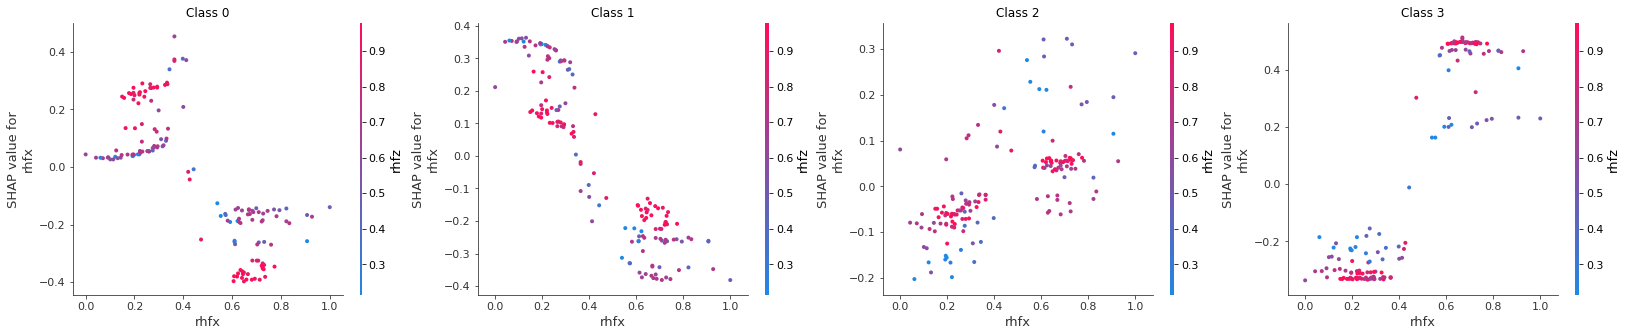

In [85]:
fig = plt.figure(figsize=(60,10))
for i in range(nclasses):
    ax = fig.add_subplot(1,nclasses,i+1)
    shap.dependence_plot('rhfx', shap_values[i], X, show=False)
    plt.title('Class %d'%i) 
plt.subplots_adjust(right=3)
plt.show()

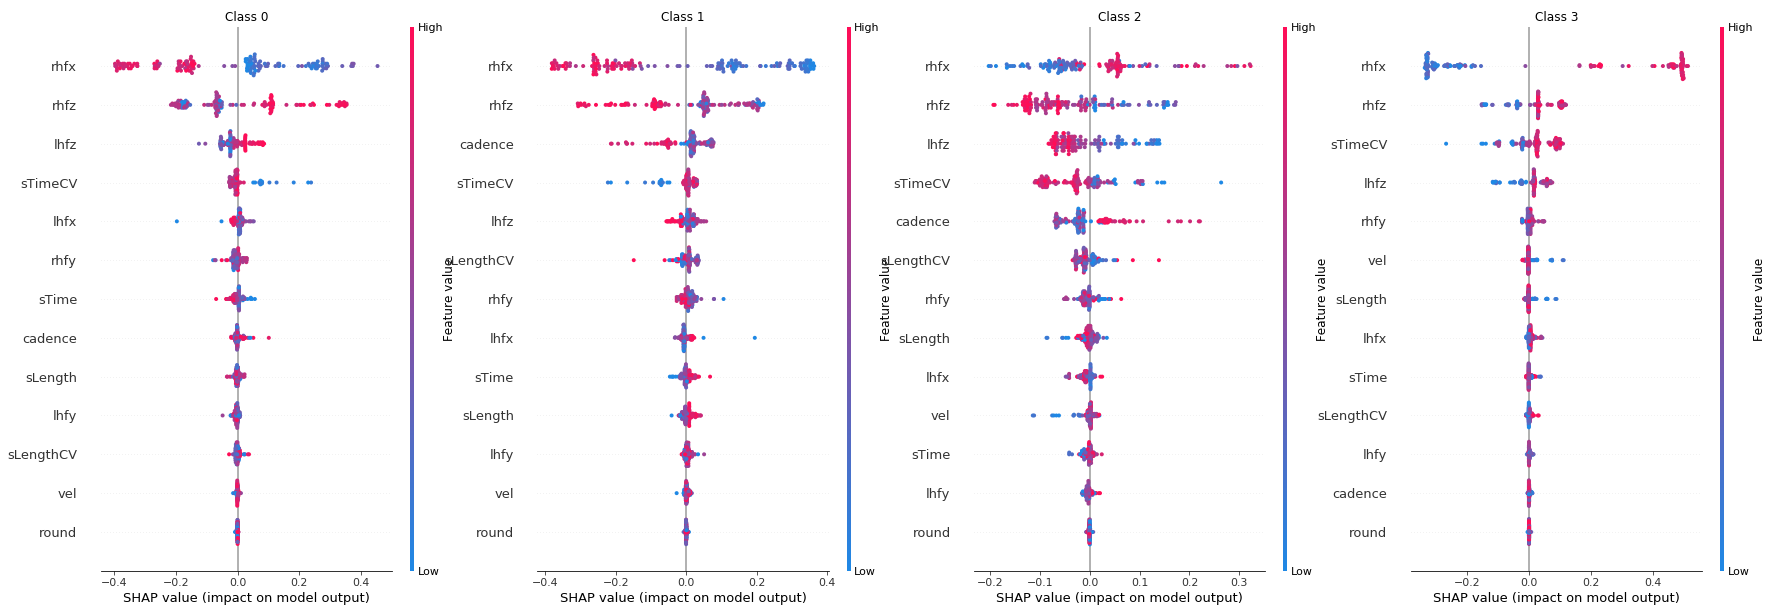

In [86]:

fig = plt.figure(figsize=(30,10))
for i in range(nclasses):
    ax = fig.add_subplot(1,nclasses,i+1)
    shap.summary_plot(shap_values[i], X, show=False,auto_size_plot=False)
    plt.title('Class %d'%i) 
plt.show()



In [87]:
shap_interaction_values = shap.TreeExplainer(clf).shap_interaction_values(X)

<Figure size 5760x720 with 0 Axes>

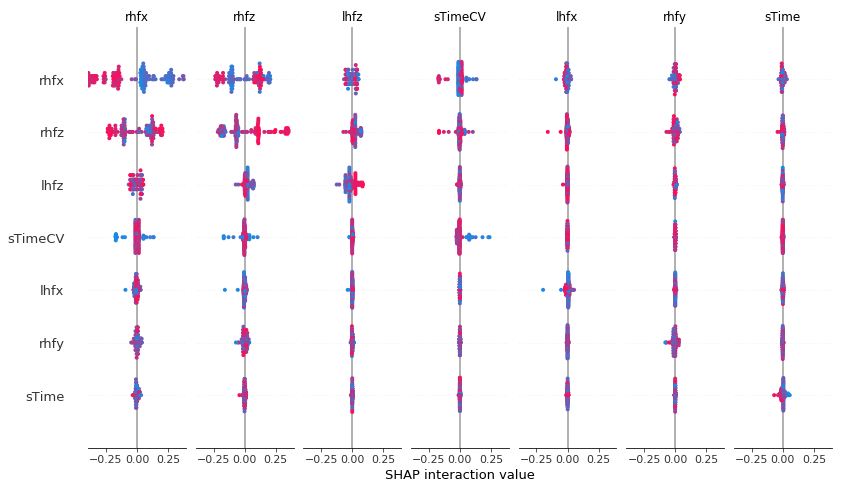

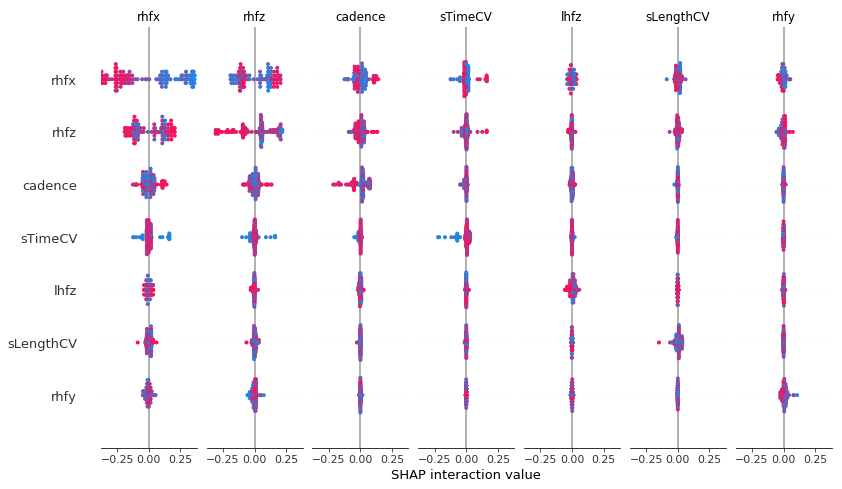

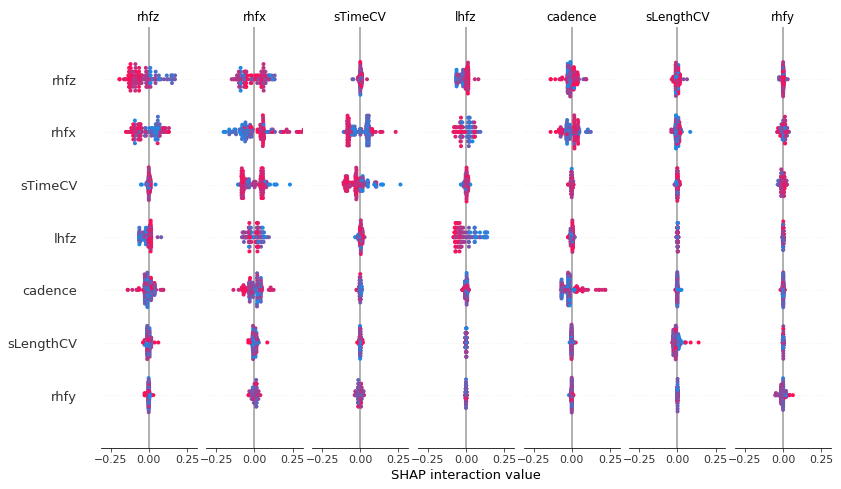

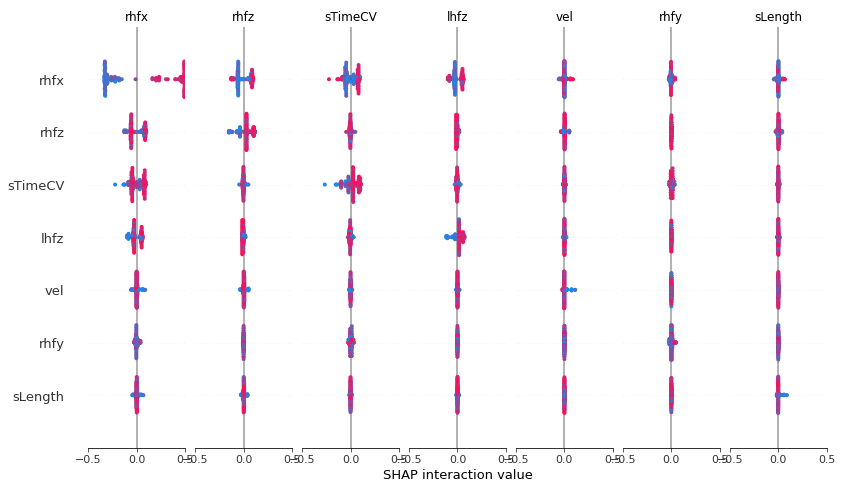

In [88]:
fig = plt.figure(figsize=(80,10))
for i in range(nclasses):
    shap.summary_plot(shap_interaction_values[i], X, show=False,auto_size_plot=False)
plt.show()

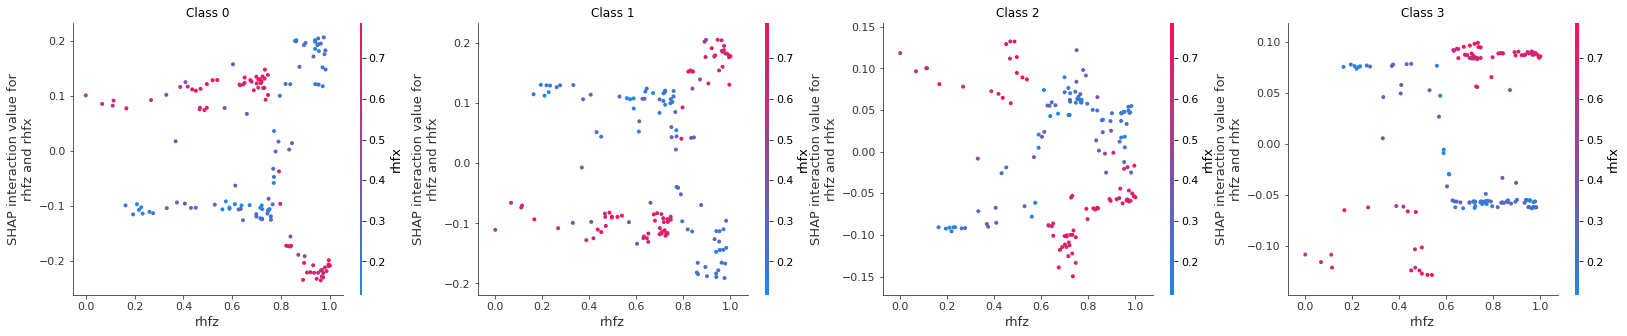

In [89]:
fig = plt.figure(figsize=(60,10))
for i in range(nclasses):
    ax = fig.add_subplot(1,nclasses,i+1)
    shap.dependence_plot(("rhfz", "rhfx"), shap_interaction_values[i], X, show=False)
    plt.title('Class %d'%i) 
plt.subplots_adjust(right=3)
plt.show()

## SVM

In [90]:
skf = StratifiedKFold(n_splits=n_splits)
skf.get_n_splits(X, y)

lacc = []
for train_index, test_index in skf.split(X, y):
    clf= classifier(num=2, SVMC=50)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    prediction = clf.predict(X_test)
    acc = accuracy_score(y_test, prediction)
    lacc.append(acc)

print('ACC mean=', np.mean(lacc))

ACC mean= 0.6979586834733894


In [91]:
clf= classifier(num=2, SVMC=50)

clf.fit(X, y)

y_hat = clf.predict(X)
print (classification_report(y_hat, y))
print (confusion_matrix(y_hat, y))
print('ACC=', accuracy_score(y, y_hat))

             precision    recall  f1-score   support

        1.0       0.69      0.76      0.72        29
        2.0       0.83      0.77      0.80        44
        3.0       0.70      0.80      0.74        20
        4.0       0.96      0.92      0.94        60

avg / total       0.84      0.83      0.83       153

[[22  6  1  0]
 [ 8 34  2  0]
 [ 1  1 16  2]
 [ 1  0  4 55]]
ACC= 0.8300653594771242


In [92]:
diff_prediction(y, y_hat)

Error instance 2, True=1, Pred=4
Error instance 27, True=1, Pred=2
Error instance 30, True=3, Pred=4
Error instance 32, True=3, Pred=4
Error instance 36, True=4, Pred=3
Error instance 37, True=4, Pred=3
Error instance 39, True=3, Pred=4
Error instance 48, True=2, Pred=3
Error instance 70, True=1, Pred=3
Error instance 71, True=1, Pred=2
Error instance 72, True=1, Pred=2
Error instance 73, True=1, Pred=2
Error instance 74, True=3, Pred=1
Error instance 75, True=3, Pred=2
Error instance 77, True=3, Pred=2
Error instance 84, True=2, Pred=1
Error instance 90, True=2, Pred=1
Error instance 91, True=2, Pred=1
Error instance 92, True=2, Pred=1
Error instance 93, True=2, Pred=1
Error instance 114, True=2, Pred=1
Error instance 127, True=1, Pred=2
Error instance 130, True=1, Pred=2
Error instance 137, True=1, Pred=2
Error instance 139, True=1, Pred=2
Error instance 149, True=3, Pred=4


In [93]:
expl = eli5.explain_weights(clf, feature_names=fnames)

show_html_expl(expl)

## Decision Tree

In [94]:
clf= DecisionTreeClassifier()

clf.fit(XNN, y)

y_hat = clf.predict(XNN)
print (classification_report(y_hat, y))
print (confusion_matrix(y_hat, y))
print('ACC=', accuracy_score(y, y_hat))
expl = eli5.explain_weights(clf, feature_names=fnames, rotate=True, filled=True, leaves_parallel=True, proportion=True)

show_html_expl(expl)

             precision    recall  f1-score   support

        1.0       1.00      1.00      1.00        32
        2.0       1.00      1.00      1.00        41
        3.0       1.00      1.00      1.00        23
        4.0       1.00      1.00      1.00        57

avg / total       1.00      1.00      1.00       153

[[32  0  0  0]
 [ 0 41  0  0]
 [ 0  0 23  0]
 [ 0  0  0 57]]
ACC= 1.0
